# Music vs. Speech Classification with Deep Learning

This tutorial shows how different Convolutional Neural Network architectures are used for the task of discriminating a piece of audio whether it is music or speech (binary classification).

The data set used is the [Music Speech](http://marsyasweb.appspot.com/download/data_sets/) data set compiled by George Tzanetakis. It consists of 128 tracks, each 30 seconds long. Each class (music/speech) has 64 examples. The tracks are all 22050Hz Mono 16-bit audio files in .wav format.

### Table of Contents

This tutorial contains:
* Loading and preprocessing of audio files
* Loading class files from CSV and using Label Encoder
* Audio Preprocessing: Generating log Mel spectrograms
* Standardization of Data
* Convolutional Neural Networks: single, stacked, parallel
* ReLU Activation
* Dropout
* Train/Test set split

You can execute the following code blocks by pressing SHIFT+Enter consecutively.

### Download Data

**On the lab machine this data is already prepared, no need to download.**

The data set can be downloaded from [here](http://opihi.cs.uvic.ca/sound/music_speech.tar.gz). Please unpack it (it is .tar.gz compressed)

Set the path to the unpacked folder in the next box:

In [1]:
# if you use the iDSDL Lab machine
DATA_PATH = '/home/ffg/idsdlmteacher1/Code/DeepLearningTutorial_2019/data/Music_speech'
# if you downloaded the dataset into the tutorial folder (otherwise adjust the DATA_PATH please)
# DATA_PATH = './Music_speech'

In [2]:
# if you want to use Multi-GPU set this before the import of keras or tensorflow:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
# General Imports
import argparse
import csv
import datetime
import glob
import librosa  # for audio loading and preprocessing
import math
import numpy as np
import os
import pandas as pd  # for reading CSV files and easier metadata preparation
import sys
import time

# Deep Learning
from keras.backend import floatx  # abstract default float type for Keras (e.g. float32)
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

Using TensorFlow backend.


## Load the Metadata

The tab-separated file contains pairs of filename TAB class.

In [4]:
csv_file = os.path.join(DATA_PATH,'filelist_wclasses.txt')
metadata = pd.read_csv(csv_file, index_col=0, sep='\t', header=None)
metadata.head(10)

,1
0,
speech/stupid.wav,speech
speech/teachers2.wav,speech
speech/danie1.wav,speech
speech/oneday.wav,speech
speech/jvoice.wav,speech
speech/relation.wav,speech
speech/geography.wav,speech
speech/pulp2.wav,speech
speech/greek1.wav,speech


In [5]:
# create two lists: one with filenames and one with associated classes
filelist = metadata.index.tolist()
classes = metadata[1].values.tolist()

## Encode Labels to Numbers

String labels need to be encoded as numbers. We use the LabelEncoder from the scikit-learn package.

In [6]:
classes[0:5]

['speech', 'speech', 'speech', 'speech', 'speech']

In [7]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labelencoder.fit(classes)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))

classes_num = labelencoder.transform(classes)

2 classes: music, speech


In [8]:
# check first few classes (speech)
classes_num[0:5]

array([1, 1, 1, 1, 1])

In [9]:
# check first few classes (music)
classes_num[-5:]

array([0, 0, 0, 0, 0])

Note: In order to correctly re-transform any predicted numbers into strings, we keep the labelencoder for later.

## Load the Audio Files

The audio is stored as .WAV files. We can load them directly. Otherwise tools like ffmpeg can help to decode. librosa.load supports the use of ffmpeg.

Audio files are usually preprocessed the following way before using them as input to a CNN:
* Conversion to Mono
* Cut a segment (or multiple, to create more instances)
* Compute a Spectrograme using FFT
* Convert to Mel scale (a psycho-acoustically motivated perceptual scale, also useful for dimension reduction)
* Convert to Log (or Decibel) scale

The FFT parameters as well as the desired number of output frames and Mel bands can be set below:

In [10]:
# SETTINGS
AUDIO_PATH = DATA_PATH

# some FFT parameters
fft_window_size = 512
fft_overlap = 0.5  # 50% overlap between successive frames

# desired spectrogram parameters as input for the CNN
frames = 80        # x axis
n_mel_bands = 40   # y axis

In [11]:
list_spectrograms = [] # spectrograms are put into a list first

# FFT parameters
frames = frames - 2  # for librosa, which otherwise creates 2 frames more than needed
hop_size = int(fft_window_size*(1-fft_overlap))
segment_size = fft_window_size + (frames-1) * hop_size  # segment size for desired # of frames

for filename in filelist:
    print(".", end='')
    
    # 1) load audio as waveform using librosa
    audiofile = os.path.join(AUDIO_PATH, filename)
    # auto-convert to mono. to preserve the native sampling rate of the file use sr=None.
    wave_data, samplerate = librosa.load(audiofile, mono=True, sr=None)
    
    # 2) use only a segment; choose start position:
    #pos = 0  # beginning
    pos = int(wave_data.shape[0]/2 - segment_size/2)  # center minus half segment size
    wav_segment = wave_data[pos:pos+segment_size]

    # 3) FFT + Mel-transform in a single step  
    spectrogram = librosa.feature.melspectrogram(y=wav_segment, sr=samplerate, 
                                                 n_fft=fft_window_size, hop_length=hop_size,
                                                 n_mels=n_mel_bands, fmax=None)
    # Note: one may want to limit the maximum frequency in the output spectrogram using the fmax parameter
    
    # 4) Log 10 transform
    spectrogram = np.log10(spectrogram)

    list_spectrograms.append(spectrogram)
        
print("\nRead", len(filelist), "audio files")

................................................................................................................................
Read 128 audio files


In [12]:
len(list_spectrograms)

128

In [13]:
wave_data.shape

(661500,)

In [14]:
wav_segment.shape

(20224,)

In [15]:
segment_size

20224

In [16]:
spectrogram.shape

(40, 80)

In [17]:
# duration of the segment in seconds
wav_segment.shape[0] / samplerate
print("An audio segment is", round(float(segment_size) / samplerate, 2), "seconds long")

An audio segment is 0.92 seconds long


Note: For simplicity of this tutorial, here we load only 1 single segment of ~ 1 second length from each audio file.
In a real setting, one would create training instances of as many audio segments as possible to be fed to a Neural Network.

### Show Waveform and Spectrogram

'music/echoes.wav'

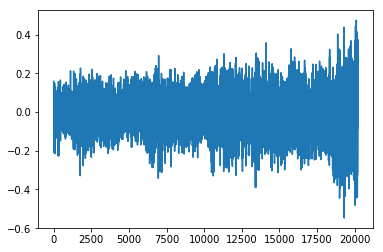

In [18]:
# you can skip this if you do not have matplotlib installed

import matplotlib.pyplot as plt
%matplotlib inline 

# show 1 sec wave segment
plt.plot(wav_segment)
filename

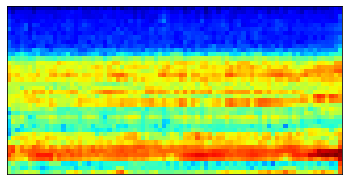

In [19]:
# show Mel spectrogram
fig = plt.imshow(spectrogram, origin='lower')
fig.set_cmap('jet')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

## Make 1 big array of list of spectrograms

In [20]:
# dtype: convert the input data to the right data type used by Keras Deep Learning (GPU) (float32)
dtype = floatx()
dtype

'float32'

In [21]:
# a list of many 40x80 spectrograms is made into 1 big array
data = np.array(list_spectrograms, dtype=dtype)
data_shape = data.shape
data_shape

(128, 40, 80)

## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

We use <b>Zero-mean Unit-variance standardization</b> (also known as Z-score normalization).
Here, we use <b>attribute-wise standardization</b>, i.e. each pixel is standardized individually, as opposed to computing a single mean and single standard deviation of all values.

('Flat' standardization would also be possible, but we have seen benefits of attribut-wise standardization in our experiments).

We use the StandardScaler from the scikit-learn package for our purpose.
As it works typically on vector data, we have to vectorize (i.e. reshape) our matrices first. After standardization we have to reshape back to the original format.

In [22]:
# vectorize
N, ydim, xdim = data.shape
data = data.reshape(N, xdim*ydim)
data.shape

(128, 3200)

In [23]:
# standardize
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(data)

In [24]:
# show mean and standard deviation: two vectors with same length as data.shape[1]
scaler.mean_, scaler.scale_

(array([-1.1095439, -1.2172654, -1.2183886, ..., -5.256482 , -5.2489576,
        -5.1149335], dtype=float32),
 array([1.0662463, 1.0477929, 1.0343325, ..., 1.0074166, 0.9897123,
        0.9291812], dtype=float32))

In [25]:
# reshape back to the original format
data = data.reshape(data_shape)

# Creating Train & Test Set 

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

Here we compare Random Split vs. Stratified Split:

In [26]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

# Normal (random) split of data set into 2 parts
# from sklearn.model_selection import train_test_split

train_set, test_set, train_classes, test_classes = train_test_split(data, classes_num, test_size=testset_size, random_state=0)

In [27]:
train_classes

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1])

In [28]:
test_classes

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0])

In [29]:
# The two classes may be unbalanced
print("Class Counts: Class 0:", sum(train_classes==0), "Class 1:", sum(train_classes))

Class Counts: Class 0: 49 Class 1: 47


In [30]:
# better: Stratified Split retains the class balance in both sets
# from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes_num)

for train_index, test_index in splits:
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]
# Note: this for loop is only executed once, if n_iter==1 resp. n_splits==1

TRAIN INDEX: [ 97 102   0  34  13  44  60  20  75  22   6  24  99 116  47  61  14 126
  68 104  89  17  95   7  37   3  93   8  40   9  69 122  72 119  71  82
  33  74  51  49  78  29  76  98   5  50 121  23  12 105  36  96  25  90
 101  55  92  21  80   2 125  16  32 127 124  48  28 112  63 110  77 109
  54  79  45  53  66 115  86 120  52  59  81 118 106  19  43  94  65  15
  26  84  30 107  10  91]
TEST INDEX: [  1  27  64 117  88  85  35  18  46 100 111  11  83 103  87   4  70  31
 108  58  57 123  38  73  56 113  67  39 114  42  41  62]


In [31]:
print(train_set.shape)
print(test_set.shape)
# Note: we will reshape the data later back to matrix form 

(96, 40, 80)
(32, 40, 80)


In [32]:
print("Class Counts: Class 0:", sum(train_classes==0), "Class 1:", sum(train_classes))

Class Counts: Class 0: 48 Class 1: 48


# Convolutional Neural Networks

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images or spectrograms, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which aggregates neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

## Preparing the Data

### Adding the channel

As CNNs were initially made for image data, we need to add a dimension for the color channel to the data. RGB images typically have a 3rd dimension with the color. 

<b>Spectrograms, however, are considered like greyscale images, as in the previous tutorial.
Likewise we need to add an extra dimension for compatibility with the CNN implementation.</b>

In [33]:
# verify image data format (Tensorflow: channels_last) 
#keras.backend.image_data_format()

In [34]:
train_set.shape

(96, 40, 80)

In [35]:
test_set.shape

(32, 40, 80)

In [36]:
n_channels = 1
N, height, width = train_set.shape
train_set = train_set.reshape(N, height, width, n_channels)  # Tensorflow ordering: channel last
N, height, width = test_set.shape
test_set = test_set.reshape(N, height, width, n_channels)  # height and width must be the same shape as train_set

In [37]:
train_set.shape

(96, 40, 80, 1)

In [38]:
test_set.shape

(32, 40, 80, 1)

In [39]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of images)
input_shape = train_set.shape[1:]  
input_shape

(40, 80, 1)

# Creating Neural Network Models in Keras

## Sequential Models

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are the standard case. Graph models are for parallel networks.

## Creating a Single Layer and a Two Layer CNN

Try: (comment/uncomment code in the following code block)
* 1 Layer
* 2 Layer
* more conv_filters
* Dropout

In [40]:
#np.random.seed(0) # make results repeatable

model = Sequential()

#conv_filters = 16   # number of convolution filters (= CNN depth)
conv_filters = 32   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Conv2D(conv_filters, (3, 3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 

# Layer 2
#model.add(Conv2D(conv_filters, (3, 3)))
#model.add(MaxPooling2D(pool_size=(2, 2))) 

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(256, activation='sigmoid')) 

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

If you get OverflowError: Range exceeds valid bounds in the above box, check the correct Theano vs. Tensorflow ordering in the box before and your keras.json configuration file.

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 78, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 39, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 39, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23712)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6070528   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 6,071,105
Trainable params: 6,071,105
Non-trainable params: 0
_________________________________________________________________


## Training the CNN

In [42]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [43]:
# TRAINING the model
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)

Epoch 1/15
96/96 [==============================] - 1s 8ms/step - loss: 0.7308 - acc: 0.5000
Epoch 2/15
96/96 [==============================] - 0s 1ms/step - loss: 0.5760 - acc: 0.6875
Epoch 3/15
96/96 [==============================] - 0s 1ms/step - loss: 0.5170 - acc: 0.7500
Epoch 4/15
96/96 [==============================] - 0s 1ms/step - loss: 0.4852 - acc: 0.7812
Epoch 5/15
96/96 [==============================] - 0s 1ms/step - loss: 0.4653 - acc: 0.7917
Epoch 6/15
96/96 [==============================] - 0s 996us/step - loss: 0.4423 - acc: 0.7812
Epoch 7/15
96/96 [==============================] - 0s 998us/step - loss: 0.4239 - acc: 0.8021
Epoch 8/15
96/96 [==============================] - 0s 990us/step - loss: 0.4117 - acc: 0.8125
Epoch 9/15
96/96 [==============================] - 0s 1ms/step - loss: 0.3988 - acc: 0.8333
Epoch 10/15
96/96 [==============================] - 0s 1ms/step - loss: 0.3889 - acc: 0.8438
Epoch 11/15
96/96 [==============================] - 0s 995us/s

#### Accuracy goes up pretty quickly for 1 layer on Train set! Also on Test set?

### Verifying Accuracy on Test Set

In [44]:
# always execute this, and then a box of accuracy_score below to print the result
test_pred = model.predict_classes(test_set)

In [45]:
# 1 layer
accuracy_score(test_classes, test_pred)

0.71875

In [46]:
# 2 layer
accuracy_score(test_classes, test_pred)

0.71875

In [47]:
# 2 layer + 32 convolution filters
accuracy_score(test_classes, test_pred)

0.71875

In [48]:
# 2 layer + 32 convolution filters + Dropout
accuracy_score(test_classes, test_pred)

0.71875

## Additional Parameters & Techniques

Try out more parameters and techniques: (comment/uncomment code blocks below)
* Adding ReLU activation
* Adding Batch normalization
* Adding Dropout

In [49]:
model = Sequential()

conv_filters = 16   # number of convolution filters (= CNN depth)
filter_size = (3,3)
pool_size = (2,2)

# Layer 1
model.add(Conv2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.3))

# Layer 2
model.add(Conv2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.1))

# In order to feed this to a Full(Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(256))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

In [50]:
# Compiling and training the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [51]:
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)

Epoch 1/15
96/96 [==============================] - 0s 3ms/step - loss: 0.5505 - acc: 0.7604
Epoch 2/15
96/96 [==============================] - 0s 576us/step - loss: 0.4407 - acc: 0.7708
Epoch 3/15
96/96 [==============================] - 0s 592us/step - loss: 0.4096 - acc: 0.8542
Epoch 4/15
96/96 [==============================] - 0s 595us/step - loss: 0.3725 - acc: 0.8542
Epoch 5/15
96/96 [==============================] - 0s 589us/step - loss: 0.3441 - acc: 0.8646
Epoch 6/15
96/96 [==============================] - 0s 559us/step - loss: 0.3216 - acc: 0.8854
Epoch 7/15
96/96 [==============================] - 0s 569us/step - loss: 0.3044 - acc: 0.9062
Epoch 8/15
96/96 [==============================] - 0s 584us/step - loss: 0.2887 - acc: 0.8958
Epoch 9/15
96/96 [==============================] - 0s 573us/step - loss: 0.2747 - acc: 0.9062
Epoch 10/15
96/96 [==============================] - 0s 572us/step - loss: 0.2643 - acc: 0.8958
Epoch 11/15
96/96 [==============================] 

In [52]:
# Verifying Accuracy on Test Set
test_pred = model.predict_classes(test_set)
accuracy_score(test_classes, test_pred)

0.75

## MIREX 2015 Winning Model

The following model was the winnner of the [MIREX 2015 Music/Speech Classification](https://www.music-ir.org/mirex/wiki/2015:Music/Speech_Classification_and_Detection_Results) benchmarking competition.
(It was trained for 150 epochs on another data set though.)

In [53]:
# MIREX 2015 model
model = Sequential()

conv_filters = 15   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Conv2D(conv_filters, (12, 8), padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
model.add(Activation('relu')) 
#model.add(Activation('sigmoid'))  # used in original model
model.add(MaxPooling2D(pool_size=(2, 1))) 
#model.add(Dropout(0.3))

# In order to feed this to a Full(Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(200, activation='sigmoid'))  
#model.add(Activation('relu'))
#model.add(Dropout(0.2))  # was not in original model

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

In [54]:
# Compiling and training the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [55]:
epochs = 30
history = model.fit(train_set, train_classes, batch_size=40, epochs=epochs)

Epoch 1/30
96/96 [==============================] - 1s 6ms/step - loss: 0.7202 - acc: 0.5000
Epoch 2/30
96/96 [==============================] - 0s 1ms/step - loss: 0.6415 - acc: 0.6458
Epoch 3/30
96/96 [==============================] - 0s 1ms/step - loss: 0.5861 - acc: 0.6667
Epoch 4/30
96/96 [==============================] - 0s 1ms/step - loss: 0.5511 - acc: 0.7396
Epoch 5/30
96/96 [==============================] - 0s 1ms/step - loss: 0.5218 - acc: 0.7604
Epoch 6/30
96/96 [==============================] - 0s 1ms/step - loss: 0.5031 - acc: 0.7604
Epoch 7/30
96/96 [==============================] - 0s 1ms/step - loss: 0.4810 - acc: 0.7812
Epoch 8/30
96/96 [==============================] - 0s 1ms/step - loss: 0.4675 - acc: 0.7917
Epoch 9/30
96/96 [==============================] - 0s 1ms/step - loss: 0.4505 - acc: 0.7708
Epoch 10/30
96/96 [==============================] - 0s 1ms/step - loss: 0.4323 - acc: 0.8021
Epoch 11/30
96/96 [==============================] - 0s 1ms/step - lo

In [56]:
# Verifying Accuracy on Test Set
test_pred = model.predict_classes(test_set)
accuracy_score(test_classes, test_pred)

0.78125

## Parallel CNNs: Graph Model

These are graph models with more than 1 pipeline of Convolution layers: They use **2 parallel pipelines of Convolution and Pooling**, processing the same input data in different ways.

This makes use of domain knowledge, where it is known in the Music IR domain that time and frequencies comprise different information in a Machine Learning task, which can be beneficial to process separately (depending on the use case). This is a major difference to processing images.

It has been discovered, that **CNNs for music work better**, when they have one filter that is detecting frequencies in the vertical axis, and another filter that is focused on the time axis, i.e. detecting rhythm. Consequently, this is realized in a parallel CNN, where 2 layers are not stacked after each other, but first run independently in parallel with their output being merged later.

Note that this might not hold true for using deeper networks.

To create parallel CNNs we need a "graph-based" model. In Keras this is realized via the **functional API** of the **Model() class**.
We use it to create two CNN layers that run in parallel to each other and are merged subsequently.
In the functional API, you pass the name of the previous layer in (brackets) after defining the next layer.

In [57]:
# SET DESIRED PARAMETERS
n_filters = 64 #16
activation = 'relu'  # 'sigmoid'  # or other

# MODEL DEFINITION

# Input "layer" only specifies the input shape
input = Input(input_shape)

# CNN layers
# The functional API allows to specify the predecessor in (brackets) after the new Layer function call

# Pipeline 1
conv_layer1 = Conv2D(n_filters, (10, 2), activation=activation)(input)       # vertical filter
maxpool1 = MaxPooling2D(pool_size=(1,2))(conv_layer1) # horizontal pooling

# Pipeline 2 (starting with same input)
conv_layer2 = Conv2D(n_filters, (2, 10), activation=activation)(input)       # horizontal filter
maxpool2 = MaxPooling2D(pool_size=(2,1))(conv_layer2) # vertical pooling

# we have to flatten the Pooling output of both pipelines in order to be concatenated
flat1 = Flatten()(maxpool1)
flat2 = Flatten()(maxpool2)

# Then we can merge (concatenate) the 2
merged = concatenate([flat1, flat2])

# we add a Dense layer after the merging
full = Dense(256, activation=activation)(merged)

# and the Output layer
output_layer = Dense(1, activation='sigmoid')(full)

# finally create the model: define input and output layer
model = Model(inputs=input, outputs=output_layer)

In [58]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 80, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 31, 79, 64)   1344        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 39, 71, 64)   1344        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 31, 39, 64)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [59]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [60]:
# TRAINING the model
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)

Epoch 1/15
96/96 [==============================] - 3s 27ms/step - loss: 0.5803 - acc: 0.6354
Epoch 2/15
96/96 [==============================] - 1s 7ms/step - loss: 0.3932 - acc: 0.8229
Epoch 3/15
96/96 [==============================] - 1s 7ms/step - loss: 0.2994 - acc: 0.8958
Epoch 4/15
96/96 [==============================] - 1s 7ms/step - loss: 0.3044 - acc: 0.8646
Epoch 5/15
96/96 [==============================] - 1s 6ms/step - loss: 0.2254 - acc: 0.9375
Epoch 6/15
96/96 [==============================] - 1s 6ms/step - loss: 0.2059 - acc: 0.9271
Epoch 7/15
96/96 [==============================] - 1s 6ms/step - loss: 0.1835 - acc: 0.9583
Epoch 8/15
96/96 [==============================] - 1s 6ms/step - loss: 0.1613 - acc: 0.9479
Epoch 9/15
96/96 [==============================] - 1s 6ms/step - loss: 0.1226 - acc: 0.9896
Epoch 10/15
96/96 [==============================] - 1s 6ms/step - loss: 0.1114 - acc: 0.9896
Epoch 11/15
96/96 [==============================] - 1s 7ms/step - l

### Verifying Accuracy on Test Set

Note: The functional API, i.e. Model() does not have a convenience method `.predict_classes()`. We therefore do 'raw' predictions with `predict()`, which returns values between 0 and 1, and then round to the nearest value (0 or 1).

In [61]:
test_pred = model.predict(test_set)
#test_pred[0:35,0]

In [62]:
test_pred = np.round(test_pred)
accuracy_score(test_classes, test_pred)

0.75

# Home Exercises 2

* **Exercise 2.1)** Adjust the model defined under "Additional Parameters & Techniques" adapting Dropout and using different activation functions such as ReLU, Leaky ReLu, PRELU, ELU or SELU. 
* **Exercise 2.2)** Adjust the model defined under "Parallel CNNs: Graph Model" experimenting with different filter shapes in each pipeline, adding additional Conv layers per pipeline, adding a 3rd pipeline (and optionally experimenting with n_filters, activation, and Dropout).

For both exercises:
* try to improve the accuaracy on the test set
* submit the adapted code including parameters, and the achieved accuaracy score on the test set.